In [9]:
import os
import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

import open_clip
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# pick which 
# model you want
model_name = "ViT-B-32"
pretrained = "openai"

# this returns (model, preprocess_transforms)
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

# freeze CLIP backbone
for param in model.parameters():
    param.requires_grad = False


/home/maker/.conda/envs/appliedAI/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [ ]:
##Data Preprocessing

data_dir = Path("trashnet/dataset-original")
dataset = ImageFolder(data_dir, transform=preprocess)

#split into train and test
dataset_size = len(dataset)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(dataset_size * train_ratio)
test_size = int(dataset_size * test_ratio)
val_size = dataset_size - train_size - test_size #guarantees it adds up to datset_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

classes = train_ds.dataset.classes
print("Detected classes:", classes)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Detected classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
def extract_features(loader, model, device):
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = model.encode_image(images)
            feats = feats.cpu()  # move to CPU to save memory
            all_features.append(feats)
            all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)


print("Extracting train features...")
train_feats, train_labels = extract_features(train_loader, model, DEVICE)
print("Extracting val features...")
val_feats, val_labels = extract_features(val_loader, model, DEVICE)
print("Extracting test features...")
test_feats, test_labels = extract_features(test_loader, model, DEVICE)

# Wrap them in TensorDatasets for fast training
train_cached = TensorDataset(train_feats, train_labels)
val_cached = TensorDataset(val_feats, val_labels)
test_cached = TensorDataset(test_feats, test_labels)

train_loader = DataLoader(train_cached, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_cached, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_cached, batch_size=batch_size, shuffle=False)

print("Feature caching complete!")

Extracting train features...
Extracting val features...
Extracting test features...
Feature caching complete!


In [12]:
feature_dim = train_feats.shape[1]
learning_rate = 1e-3
weight_decay = 1e-4

classifier = nn.Sequential(
    nn.Linear(feature_dim, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
).to(DEVICE)

optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

num_epochs = 500
accuracies = []
avg_losses = []

for epoch in range(num_epochs):
    classifier.train()
    losses = []

    for feats, labels in train_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        logits = classifier(feats)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = np.mean(losses)
    avg_losses.append(avg_loss)

    # Validation
    classifier.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for feats, labels in val_loader:
            feats, labels = feats.to(DEVICE), labels.to(DEVICE)
            logits = classifier(feats)
            preds = logits.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_loss:.4f} - Val acc: {acc:.4f}")



Epoch 1/500 - Train loss: 1.1824 - Val acc: 0.8206
Epoch 2/500 - Train loss: 0.4771 - Val acc: 0.8522
Epoch 3/500 - Train loss: 0.3305 - Val acc: 0.8628
Epoch 4/500 - Train loss: 0.2602 - Val acc: 0.8786
Epoch 5/500 - Train loss: 0.2290 - Val acc: 0.8707
Epoch 6/500 - Train loss: 0.1947 - Val acc: 0.8918
Epoch 7/500 - Train loss: 0.1769 - Val acc: 0.8997
Epoch 8/500 - Train loss: 0.1498 - Val acc: 0.9156
Epoch 9/500 - Train loss: 0.1352 - Val acc: 0.9050
Epoch 10/500 - Train loss: 0.1210 - Val acc: 0.9050
Epoch 11/500 - Train loss: 0.1067 - Val acc: 0.9156
Epoch 12/500 - Train loss: 0.0941 - Val acc: 0.9235
Epoch 13/500 - Train loss: 0.0839 - Val acc: 0.9208
Epoch 14/500 - Train loss: 0.0742 - Val acc: 0.9208
Epoch 15/500 - Train loss: 0.0714 - Val acc: 0.9129
Epoch 16/500 - Train loss: 0.0592 - Val acc: 0.9182
Epoch 17/500 - Train loss: 0.0597 - Val acc: 0.9129
Epoch 18/500 - Train loss: 0.0494 - Val acc: 0.9182
Epoch 19/500 - Train loss: 0.0445 - Val acc: 0.9182
Epoch 20/500 - Train 

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.96      0.98        54
       glass       0.95      0.95      0.95        83
       metal       1.00      0.96      0.98        71
       paper       0.93      0.93      0.93        89
     plastic       0.89      0.95      0.92        60
       trash       0.79      0.83      0.81        23

    accuracy                           0.94       380
   macro avg       0.93      0.93      0.93       380
weighted avg       0.94      0.94      0.94       380



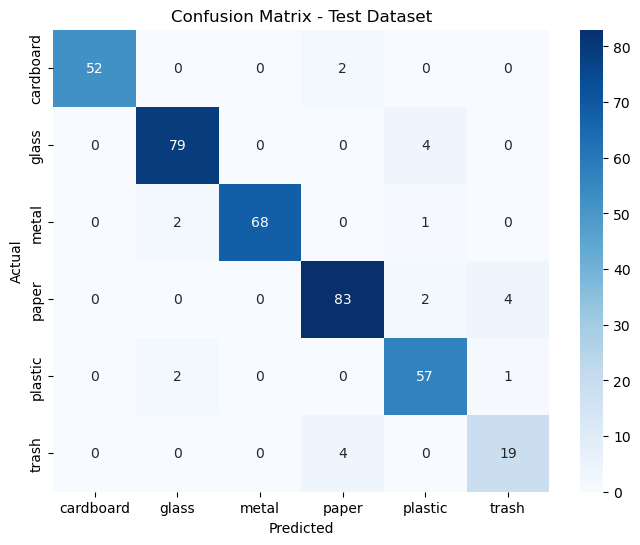

In [13]:
classifier.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for feats, labels in test_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        logits = classifier(feats)
        preds = logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Dataset')
plt.show()


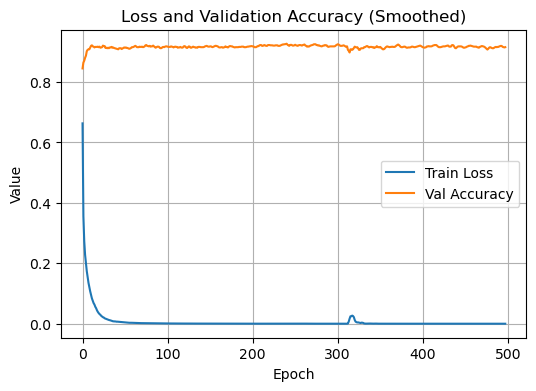

Average of last 25 epochs: 
Accuracy: 0.9148284960422163
Average loss : 4.1875078887382454e-05


In [14]:
def smooth(data, window=3):
    """Simple moving average smoothing"""
    return np.convolve(data, np.ones(window)/window, mode='valid')

def tail_n_average(data, window=3):
    """Return the average of the last n datapoints"""
    return np.mean(data[-window:])

# Smooth the curves
smoothed_losses = smooth(avg_losses, window=3)
smoothed_accs = smooth(accuracies, window=3)

plt.figure(figsize=(6,4))
plt.plot(smoothed_losses, label='Train Loss')
plt.plot(smoothed_accs, label='Val Accuracy')
#plt.plot(tail_n_average(smoothed_losses, 25), label='test')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Loss and Validation Accuracy (Smoothed)')
plt.grid(True)
plt.show()

n = 25
average_acc = tail_n_average(smoothed_accs, n)
average_loss = tail_n_average(smoothed_losses, n)

print(f"Average of last {n} epochs: ")
print(f"Accuracy: {average_acc}")
print(f"Average loss : {average_loss}")